In [1]:
import sys
sys.path.append('../..')
import scripts.radossim as sim
import matplotlib.pyplot as plt
print('done.')

done.


In [2]:
def printResults(avgThroughput, avgOsdQueueLen, data, timeLog=None, batchSizeLog=None):
    print()
    print('Results:')
    print(f'\t avg Throughput: {avgThroughput} MB/s')
    print(f'\t avg Osd Queue Size: {avgOsdQueueLen}')
    avgBlueStoreLat = 0
    avgKVQueueLat = 0
    for (((((_, _, _), _), arrivalKV), _, _), kvQDispatch, kvCommit) in data:
        avgBlueStoreLat += kvCommit - arrivalKV
        avgKVQueueLat += kvQDispatch - arrivalKV
    avgBlueStoreLat /= len(data)
    avgKVQueueLat /= len(data)
    avgBlueStoreLat /= 1_000
    avgKVQueueLat /= 1_000
    print(f'\t avg BlueStore Latency: {avgBlueStoreLat} ms')
    print(f'\t avg KV Queue Latency: {avgKVQueueLat} ms')
    print()
    time = [arrivalKV for (((((_, _, _), _), arrivalKV), _, _), _, _) in data]
    kvQueueLats = [kvQDispatch - arrivalKV for (((((_, _, _), _), arrivalKV), _, _), kvQDispatch, _) in data]
    fig, ax = plt.subplots(figsize=(8, 4))
    ax.grid(True)
    ax.set_xlabel('time')
    if batchSizeLog:
        ax.plot(timeLog, batchSizeLog, color='green', label='Batch Size History')
        fig, ax = plt.subplots(figsize=(8, 4))
    ax.plot(time, kvQueueLats, color='red', label='KV Queuing Latency')
    plt.show()

def printTitle(title):
    print('************************************************')
    print(title)
    print('************************************************')
    print()
    
def printSeparator():
    print()
    print('=========================================================')
    print()

In [5]:
def runSimulations(targetLatSettings = [100],
                   intervalSettings = [1000],
                   batchDownSizeSettings = [2],
                   batchUpSizeSettings = [1],
                   simulationTimeSettings = [30 * 1_000_000],
                   modelPath = '../latModel/latency_model_4K.yaml',
                   adaptive=False,
                   upSizeLimitSettings=[False]
                  ):
    printTitle('Simulation without CoDel')

    print('Simulation running...')
    avgThroughput, avgOsdQueueLen, data, _, _ = sim.runSimulation(
        modelPath,
        0,
        0,
        simulationTimeSettings[0],
        useCoDel=False,
        downSize=1,
        upSize=1,
        adaptive=adaptive,
        upSizeLimit=False
    )
    avgThroughput = avgThroughput / 1024
    avgThroughput = avgThroughput / 1024
    print('Simulation done')

    printResults(avgThroughput, avgOsdQueueLen, data)


    printTitle('Simulation with CoDel')

    i = 1
    for time in simulationTimeSettings:
        for targetLat in targetLatSettings:
            for interval in intervalSettings:
                for downSize in batchDownSizeSettings:
                    for upSize in batchUpSizeSettings:
                        for upSizeLimit in upSizeLimitSettings:
                            print(f'Simulation profile #{i}:')
                            print(f'\t time: {time}')
                            print(f'\t targetLat: {targetLat}')
                            print(f'\t interval: {interval}')
                            print(f'\t downSize: {downSize}')
                            print(f'\t upSize: {upSize}')
                            print(f'\t upSizeLimit: {upSizeLimit}')
                            print()
                            print('\t Simulation running...')
                            avgThroughput, avgOsdQueueLen, data, timeLog, batchSizeLog = sim.runSimulation(
                                modelPath,
                                targetLat,
                                interval,
                                time,
                                useCoDel=True,
                                downSize=downSize,
                                upSize=upSize,
                                adaptive=adaptive,
                                upSizeLimit=upSizeLimit
                            )
                            avgThroughput = avgThroughput / 1024
                            avgThroughput = avgThroughput / 1024
                            print('\t Simulation done')
                            printResults(avgThroughput, avgOsdQueueLen, data, timeLog, batchSizeLog)
                            printSeparator()
                            i += 1


************************************************
Simulation without CoDel
************************************************

Simulation running...
L0 Compaction
L0 Compaction
L0 Compaction
404095.0
Simulation done

Results:
	 avg Throughput: 52.616536458333336 MB/s
	 avg Osd Queue Size: 0.4999993813512032
	 avg BlueStore Latency: 1.0765574605065213 ms
	 avg KV Queue Latency: 0.348781746175318 ms



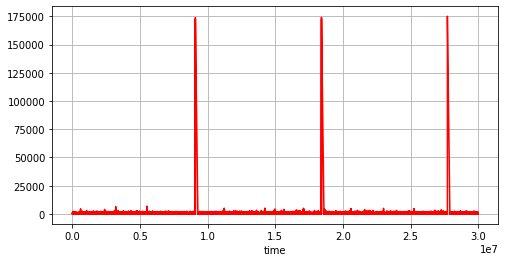

************************************************
Simulation with CoDel
************************************************

Simulation profile #1:
	 time: 30000000
	 targetLat: 100
	 interval: 1000
	 downSize: 2
	 upSize: 1
	 upSizeLimit: False

	 Simulation running...
Using CoDel algorithm ...
L0 Compaction
L0 Compaction
L0 Compaction
404446.0
	 Simulation done

Results:
	 avg Throughput: 52.66223958333333 MB/s
	 avg Osd Queue Size: 0.49999938187433013
	 avg BlueStore Latency: 1.0739905497408686 ms
	 avg KV Queue Latency: 0.3554366329875252 ms



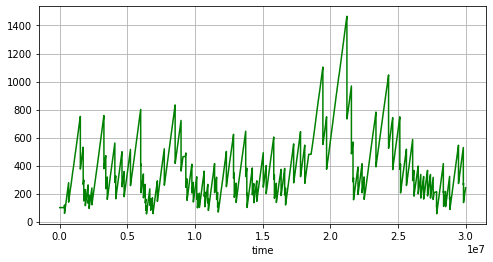

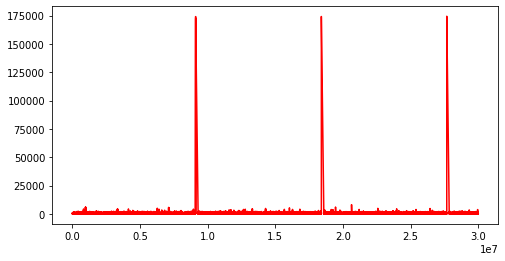



Simulation profile #2:
	 time: 30000000
	 targetLat: 100
	 interval: 1000
	 downSize: 2
	 upSize: 2
	 upSizeLimit: False

	 Simulation running...
Using CoDel algorithm ...
L0 Compaction
L0 Compaction
L0 Compaction
403200.0
	 Simulation done

Results:
	 avg Throughput: 52.5 MB/s
	 avg Osd Queue Size: 0.49999937996108634
	 avg BlueStore Latency: 1.0801196232604902 ms
	 avg KV Queue Latency: 0.35390052133073563 ms



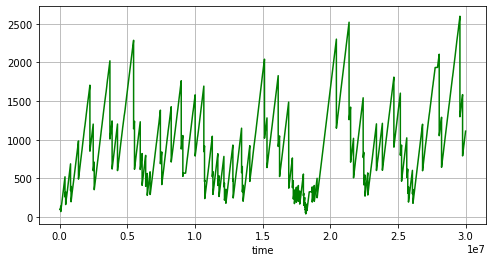

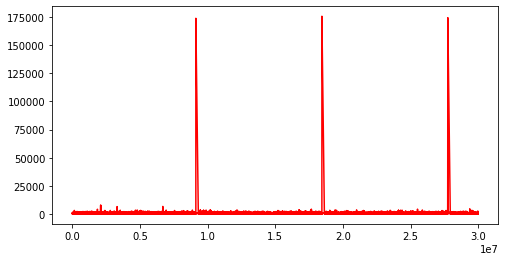



Simulation profile #3:
	 time: 30000000
	 targetLat: 100
	 interval: 1000
	 downSize: 2
	 upSize: 4
	 upSizeLimit: False

	 Simulation running...
Using CoDel algorithm ...
L0 Compaction
L0 Compaction
L0 Compaction
403105.0
	 Simulation done

Results:
	 avg Throughput: 52.487630208333336 MB/s
	 avg Osd Queue Size: 0.49999937981496156
	 avg BlueStore Latency: 1.078675108741447 ms
	 avg KV Queue Latency: 0.33745947582059144 ms



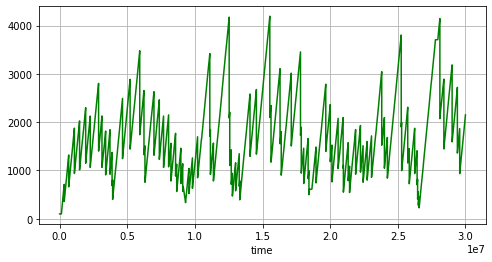

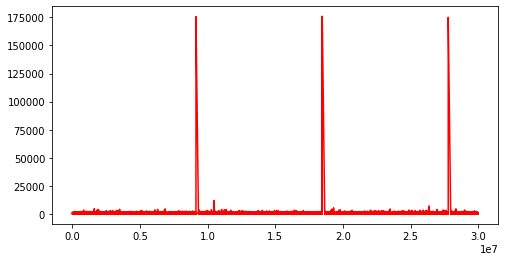



Simulation profile #4:
	 time: 30000000
	 targetLat: 100
	 interval: 1000
	 downSize: 2
	 upSize: 8
	 upSizeLimit: False

	 Simulation running...
Using CoDel algorithm ...
L0 Compaction
L0 Compaction
L0 Compaction
403617.0
	 Simulation done

Results:
	 avg Throughput: 52.554296875 MB/s
	 avg Osd Queue Size: 0.49999938060782195
	 avg BlueStore Latency: 1.080144827567738 ms
	 avg KV Queue Latency: 0.35271383828105546 ms



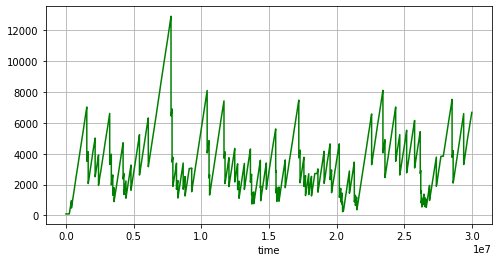

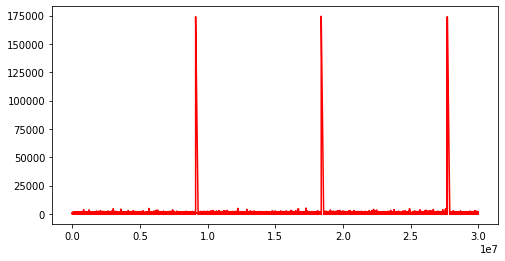



Simulation profile #5:
	 time: 30000000
	 targetLat: 100
	 interval: 1000
	 downSize: 2
	 upSize: 16
	 upSizeLimit: False

	 Simulation running...
Using CoDel algorithm ...
L0 Compaction
L0 Compaction
L0 Compaction
403493.0
	 Simulation done

Results:
	 avg Throughput: 52.538151041666666 MB/s
	 avg Osd Queue Size: 0.4999993804144036
	 avg BlueStore Latency: 1.0777442157124337 ms
	 avg KV Queue Latency: 0.3548521641854952 ms



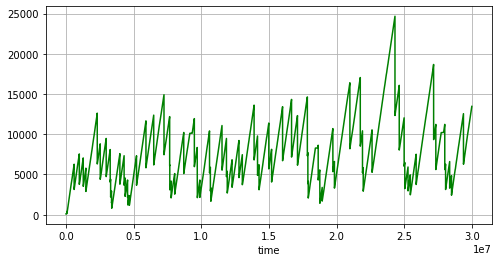

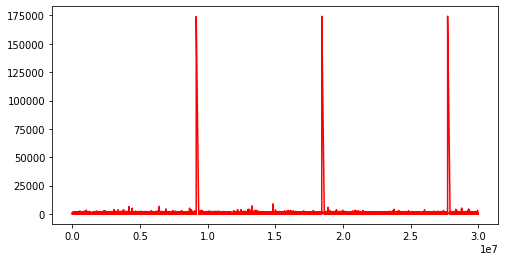



Simulation profile #6:
	 time: 30000000
	 targetLat: 100
	 interval: 1000
	 downSize: 4
	 upSize: 1
	 upSizeLimit: False

	 Simulation running...
Using CoDel algorithm ...
L0 Compaction
L0 Compaction
L0 Compaction
405233.0
	 Simulation done

Results:
	 avg Throughput: 52.764713541666666 MB/s
	 avg Osd Queue Size: 3.556212638111748
	 avg BlueStore Latency: 0.5988256003849038 ms
	 avg KV Queue Latency: 0.20256869220853704 ms



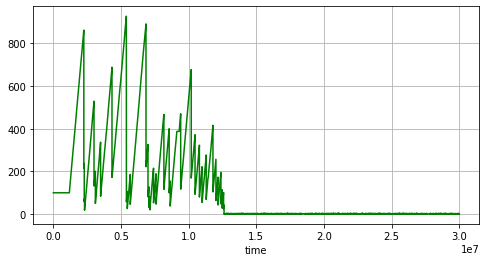

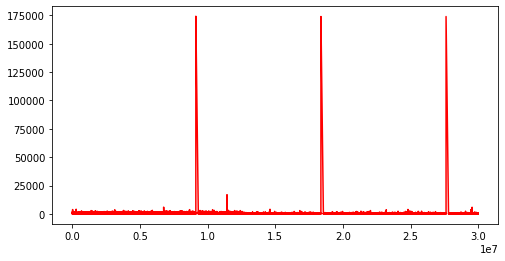



Simulation profile #7:
	 time: 30000000
	 targetLat: 100
	 interval: 1000
	 downSize: 4
	 upSize: 2
	 upSizeLimit: False

	 Simulation running...
Using CoDel algorithm ...
L0 Compaction
L0 Compaction
L0 Compaction
403104.0
	 Simulation done

Results:
	 avg Throughput: 52.4875 MB/s
	 avg Osd Queue Size: 0.4999993798134231
	 avg BlueStore Latency: 1.0809342725807847 ms
	 avg KV Queue Latency: 0.35400096690683774 ms



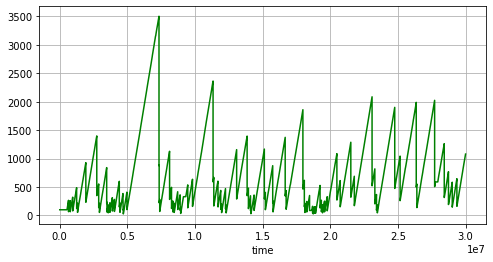

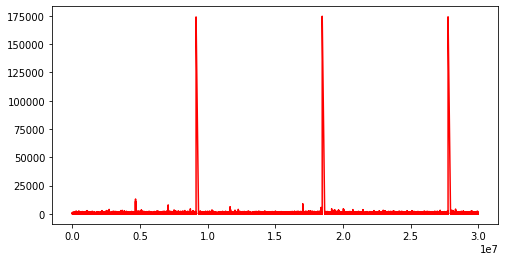



Simulation profile #8:
	 time: 30000000
	 targetLat: 100
	 interval: 1000
	 downSize: 4
	 upSize: 4
	 upSizeLimit: False

	 Simulation running...
Using CoDel algorithm ...
L0 Compaction
L0 Compaction
L0 Compaction
403683.0
	 Simulation done

Results:
	 avg Throughput: 52.562890625 MB/s
	 avg Osd Queue Size: 0.5025756564239063
	 avg BlueStore Latency: 1.074088508721486 ms
	 avg KV Queue Latency: 0.35345394030467725 ms



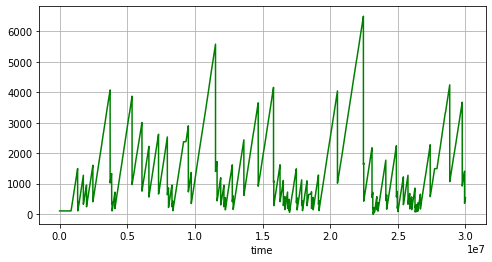

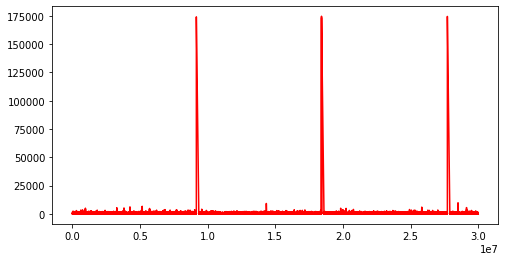



Simulation profile #9:
	 time: 30000000
	 targetLat: 100
	 interval: 1000
	 downSize: 4
	 upSize: 8
	 upSizeLimit: False

	 Simulation running...
Using CoDel algorithm ...
L0 Compaction
L0 Compaction
L0 Compaction
404420.0
	 Simulation done

Results:
	 avg Throughput: 52.658854166666664 MB/s
	 avg Osd Queue Size: 0.4999993818361198
	 avg BlueStore Latency: 1.0720948315374699 ms
	 avg KV Queue Latency: 0.35398550569648707 ms



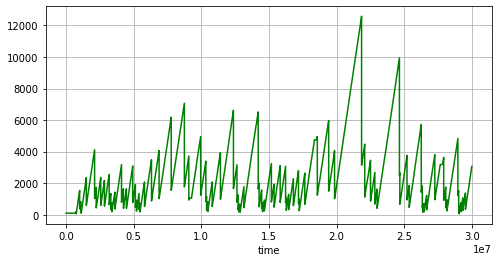

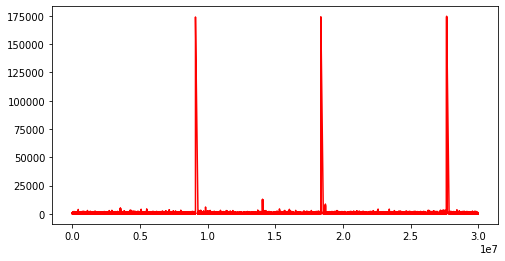



Simulation profile #10:
	 time: 30000000
	 targetLat: 100
	 interval: 1000
	 downSize: 4
	 upSize: 16
	 upSizeLimit: False

	 Simulation running...
Using CoDel algorithm ...
L0 Compaction
L0 Compaction
L0 Compaction
403553.0
	 Simulation done

Results:
	 avg Throughput: 52.545963541666666 MB/s
	 avg Osd Queue Size: 0.49999938053261805
	 avg BlueStore Latency: 1.0795239458619064 ms
	 avg KV Queue Latency: 0.35210291789448356 ms



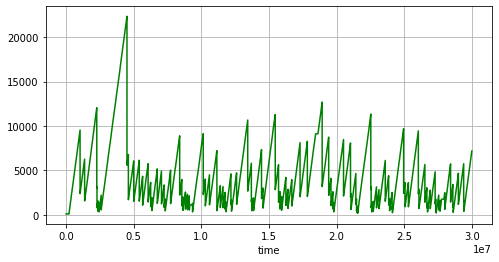

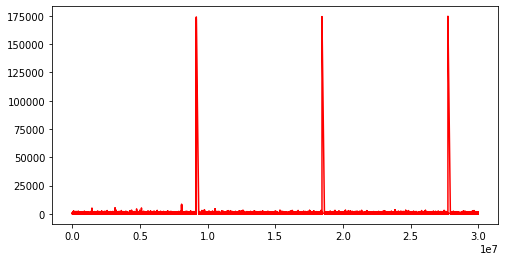



Simulation profile #11:
	 time: 30000000
	 targetLat: 100
	 interval: 1000
	 downSize: 8
	 upSize: 1
	 upSizeLimit: False

	 Simulation running...
Using CoDel algorithm ...
L0 Compaction
L0 Compaction
L0 Compaction
404139.0
	 Simulation done

Results:
	 avg Throughput: 52.622265625 MB/s
	 avg Osd Queue Size: 4.946782714124881
	 avg BlueStore Latency: 0.37176048190170163 ms
	 avg KV Queue Latency: 0.12436124241606118 ms



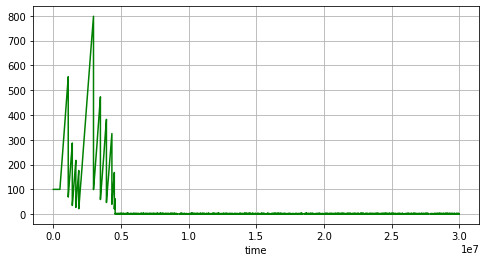

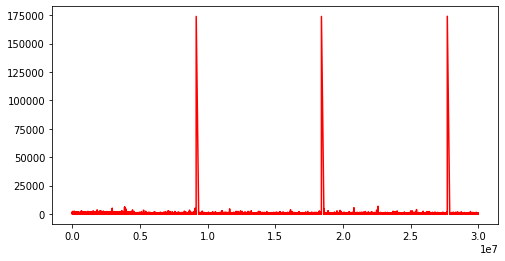



Simulation profile #12:
	 time: 30000000
	 targetLat: 100
	 interval: 1000
	 downSize: 8
	 upSize: 2
	 upSizeLimit: False

	 Simulation running...
Using CoDel algorithm ...
L0 Compaction
L0 Compaction
L0 Compaction
404574.0
	 Simulation done

Results:
	 avg Throughput: 52.67890625 MB/s
	 avg Osd Queue Size: 4.841948767128705
	 avg BlueStore Latency: 0.35388801260622 ms
	 avg KV Queue Latency: 0.13047295368365255 ms



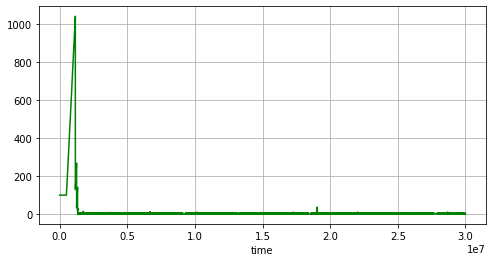

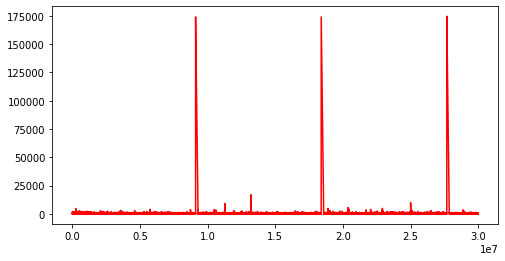



Simulation profile #13:
	 time: 30000000
	 targetLat: 100
	 interval: 1000
	 downSize: 8
	 upSize: 4
	 upSizeLimit: False

	 Simulation running...
Using CoDel algorithm ...
L0 Compaction
L0 Compaction
L0 Compaction
403920.0
	 Simulation done

Results:
	 avg Throughput: 52.59375 MB/s
	 avg Osd Queue Size: 0.4999993810663237
	 avg BlueStore Latency: 1.075963926334928 ms
	 avg KV Queue Latency: 0.35487873941680526 ms



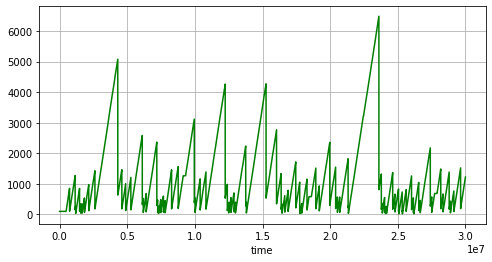

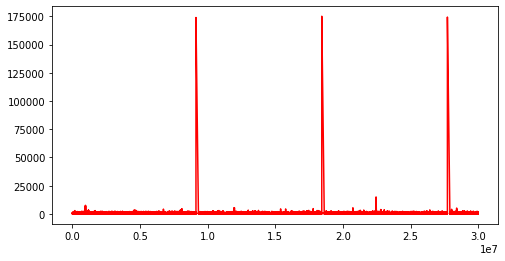



Simulation profile #14:
	 time: 30000000
	 targetLat: 100
	 interval: 1000
	 downSize: 8
	 upSize: 8
	 upSizeLimit: False

	 Simulation running...
Using CoDel algorithm ...
L0 Compaction
L0 Compaction
L0 Compaction
403551.0
	 Simulation done

Results:
	 avg Throughput: 52.545703125 MB/s
	 avg Osd Queue Size: 0.5001356683991749
	 avg BlueStore Latency: 1.0820289974786914 ms
	 avg KV Queue Latency: 0.35458291570118533 ms



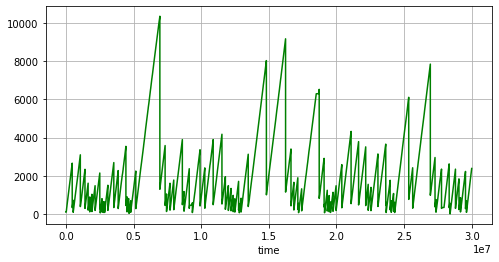

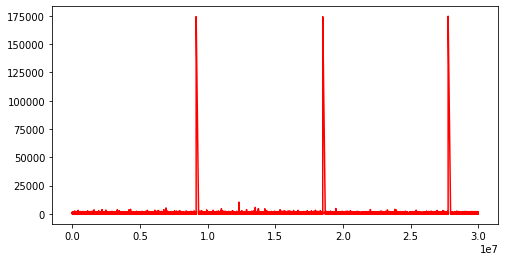



Simulation profile #15:
	 time: 30000000
	 targetLat: 100
	 interval: 1000
	 downSize: 8
	 upSize: 16
	 upSizeLimit: False

	 Simulation running...
Using CoDel algorithm ...
L0 Compaction
L0 Compaction
L0 Compaction
404065.0
	 Simulation done

Results:
	 avg Throughput: 52.612630208333336 MB/s
	 avg Osd Queue Size: 0.49999938129149213
	 avg BlueStore Latency: 1.0754497190526477 ms
	 avg KV Queue Latency: 0.35032933019760243 ms



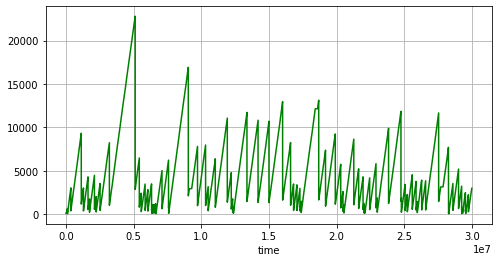

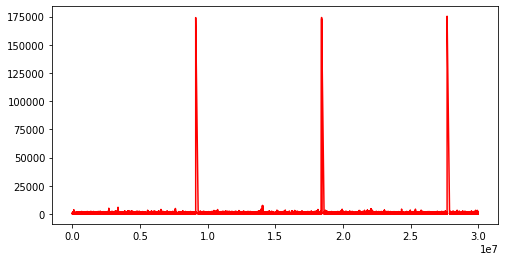



Simulation profile #16:
	 time: 30000000
	 targetLat: 100
	 interval: 1000
	 downSize: 16
	 upSize: 1
	 upSizeLimit: False

	 Simulation running...
Using CoDel algorithm ...
L0 Compaction
L0 Compaction
L0 Compaction
404169.0
	 Simulation done

Results:
	 avg Throughput: 52.626171875 MB/s
	 avg Osd Queue Size: 5.767571064865788
	 avg BlueStore Latency: 0.2570367954697933 ms
	 avg KV Queue Latency: 0.09213852493006122 ms



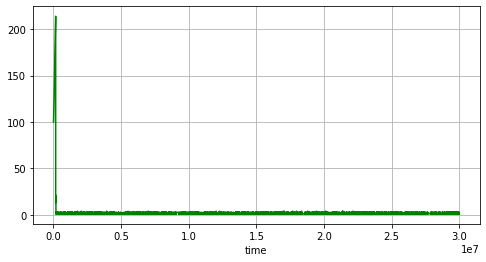

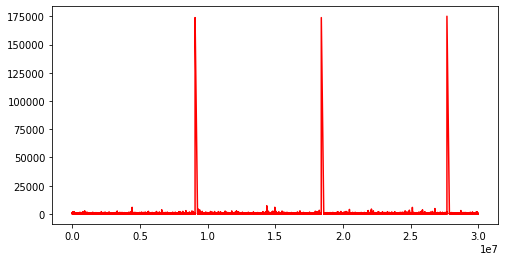



Simulation profile #17:
	 time: 30000000
	 targetLat: 100
	 interval: 1000
	 downSize: 16
	 upSize: 2
	 upSizeLimit: False

	 Simulation running...
Using CoDel algorithm ...
L0 Compaction
L0 Compaction
L0 Compaction
403090.0
	 Simulation done

Results:
	 avg Throughput: 52.485677083333336 MB/s
	 avg Osd Queue Size: 4.8429339763531445
	 avg BlueStore Latency: 0.35656239988740684 ms
	 avg KV Queue Latency: 0.13057494829810165 ms



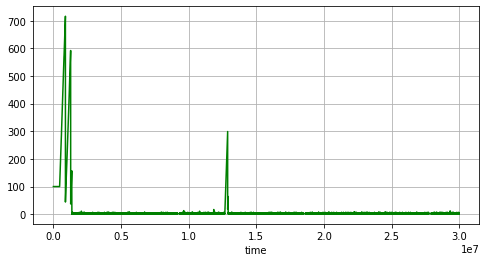

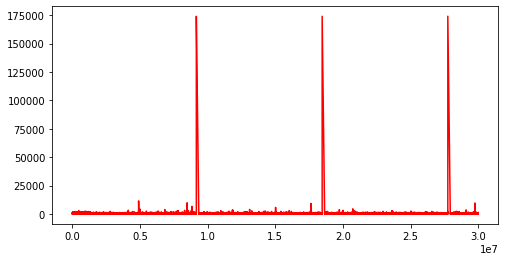



Simulation profile #18:
	 time: 30000000
	 targetLat: 100
	 interval: 1000
	 downSize: 16
	 upSize: 4
	 upSizeLimit: False

	 Simulation running...
Using CoDel algorithm ...
L0 Compaction
L0 Compaction
L0 Compaction
403249.0
	 Simulation done

Results:
	 avg Throughput: 52.50638020833333 MB/s
	 avg Osd Queue Size: 0.6354515008698088
	 avg BlueStore Latency: 1.0584373287097026 ms
	 avg KV Queue Latency: 0.3480918731385153 ms



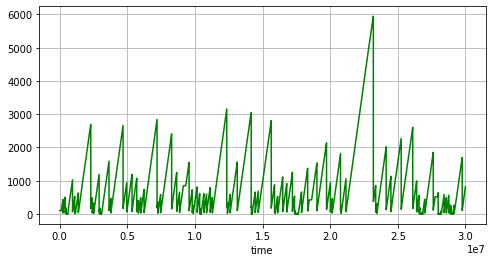

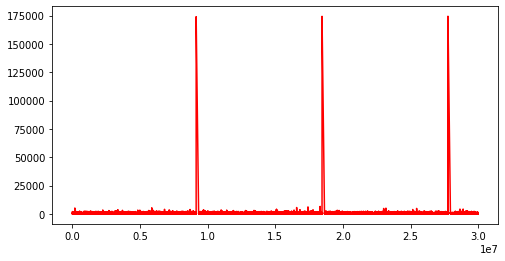



Simulation profile #19:
	 time: 30000000
	 targetLat: 100
	 interval: 1000
	 downSize: 16
	 upSize: 8
	 upSizeLimit: False

	 Simulation running...
Using CoDel algorithm ...
L0 Compaction
L0 Compaction
L0 Compaction
403776.0
	 Simulation done

Results:
	 avg Throughput: 52.575 MB/s
	 avg Osd Queue Size: 0.5219521195512864
	 avg BlueStore Latency: 1.0742229390532845 ms
	 avg KV Queue Latency: 0.35330288136094 ms



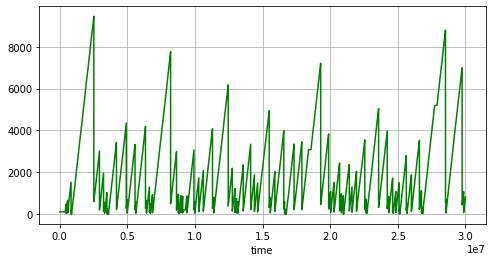

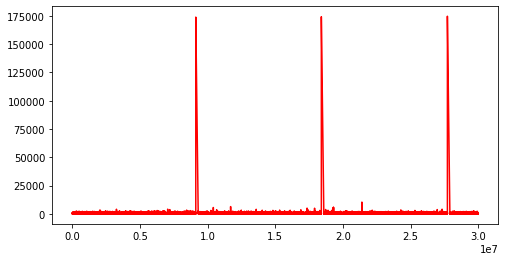



Simulation profile #20:
	 time: 30000000
	 targetLat: 100
	 interval: 1000
	 downSize: 16
	 upSize: 16
	 upSizeLimit: False

	 Simulation running...
Using CoDel algorithm ...
L0 Compaction
L0 Compaction
L0 Compaction
403958.0
	 Simulation done

Results:
	 avg Throughput: 52.598697916666666 MB/s
	 avg Osd Queue Size: 0.5010068854378498
	 avg BlueStore Latency: 1.0748092660056956 ms
	 avg KV Queue Latency: 0.3554254716477549 ms



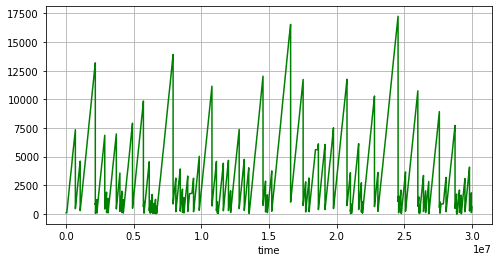

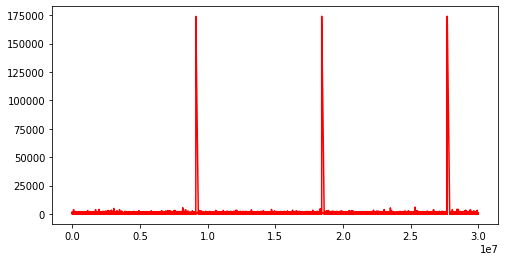

In [7]:
targetLatSettings = [100]
intervalSettings = [1000]
batchDownSizeSettings = [2, 4, 8, 16]
batchUpSizeSettings = [1, 2, 4, 8, 16]

runSimulations(targetLatSettings,
                   intervalSettings,
                   batchDownSizeSettings,
                   batchUpSizeSettings
                  )

************************************************
Simulation without CoDel
************************************************

Simulation running...
L0 Compaction
L0 Compaction
L0 Compaction
403852.0
Simulation done

Results:
	 avg Throughput: 52.584895833333334 MB/s
	 avg Osd Queue Size: 0.4999993809636415
	 avg BlueStore Latency: 1.0752197012645517 ms
	 avg KV Queue Latency: 0.3527962855235456 ms



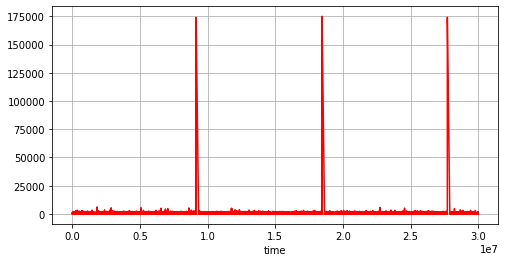

************************************************
Simulation with CoDel
************************************************

Simulation profile #1:
	 time: 30000000
	 targetLat: 50
	 interval: 1000
	 downSize: 2
	 upSize: 1
	 upSizeLimit: False

	 Simulation running...
Using CoDel algorithm ...
L0 Compaction
L0 Compaction
L0 Compaction
403440.0
	 Simulation done

Results:
	 avg Throughput: 52.53125 MB/s
	 avg Osd Queue Size: 0.4999993803299371
	 avg BlueStore Latency: 1.0716710390766768 ms
	 avg KV Queue Latency: 0.34619214164897943 ms



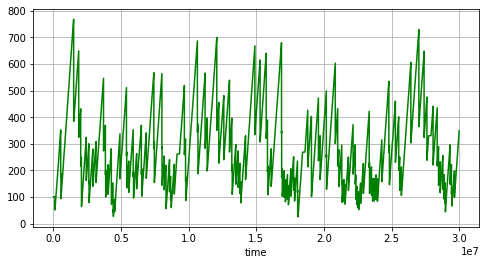

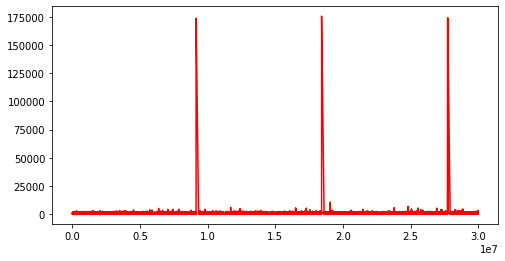



Simulation profile #2:
	 time: 30000000
	 targetLat: 50
	 interval: 1000
	 downSize: 2
	 upSize: 1
	 upSizeLimit: True

	 Simulation running...
Using CoDel algorithm ...
L0 Compaction
L0 Compaction
L0 Compaction
404828.0
	 Simulation done

Results:
	 avg Throughput: 52.711979166666666 MB/s
	 avg Osd Queue Size: 5.759258801821007
	 avg BlueStore Latency: 0.2552445114830821 ms
	 avg KV Queue Latency: 0.08810948503969651 ms



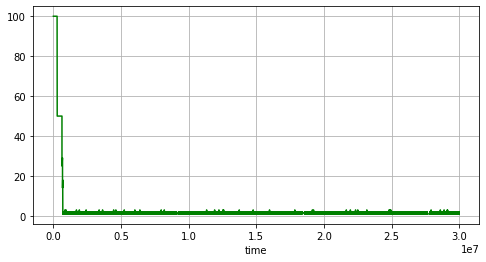

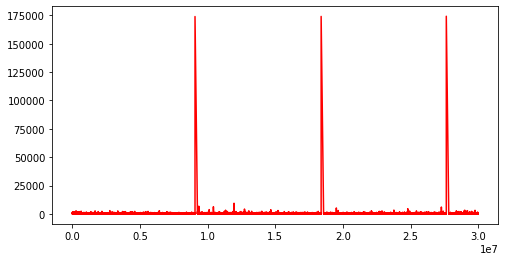



Simulation profile #3:
	 time: 30000000
	 targetLat: 100
	 interval: 1000
	 downSize: 2
	 upSize: 1
	 upSizeLimit: False

	 Simulation running...
Using CoDel algorithm ...
L0 Compaction
L0 Compaction
L0 Compaction
405394.0
	 Simulation done

Results:
	 avg Throughput: 52.78567708333333 MB/s
	 avg Osd Queue Size: 0.4999993833349983
	 avg BlueStore Latency: 1.0667128161538753 ms
	 avg KV Queue Latency: 0.35214452755117065 ms



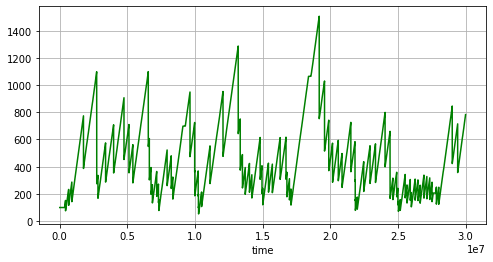

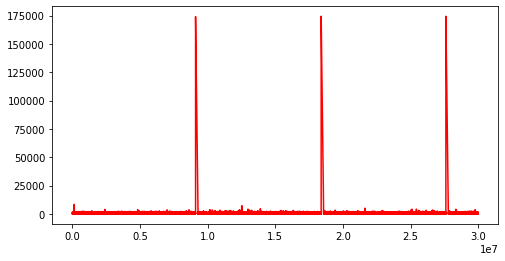



Simulation profile #4:
	 time: 30000000
	 targetLat: 100
	 interval: 1000
	 downSize: 2
	 upSize: 1
	 upSizeLimit: True

	 Simulation running...
Using CoDel algorithm ...
L0 Compaction
L0 Compaction
L0 Compaction
403283.0
	 Simulation done

Results:
	 avg Throughput: 52.510807291666666 MB/s
	 avg Osd Queue Size: 5.6897038239184905
	 avg BlueStore Latency: 0.27365929763012875 ms
	 avg KV Queue Latency: 0.09687636110671188 ms



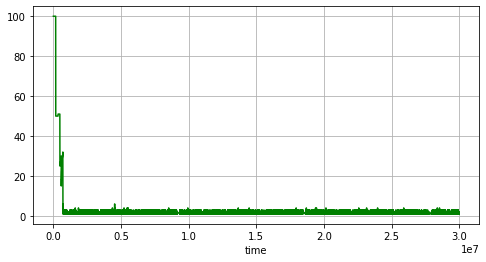

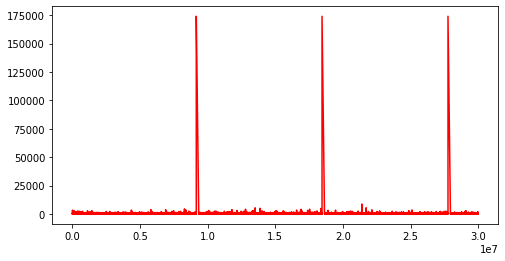



Simulation profile #5:
	 time: 30000000
	 targetLat: 200
	 interval: 1000
	 downSize: 2
	 upSize: 1
	 upSizeLimit: False

	 Simulation running...
Using CoDel algorithm ...
L0 Compaction
L0 Compaction
L0 Compaction
403872.0
	 Simulation done

Results:
	 avg Throughput: 52.5875 MB/s
	 avg Osd Queue Size: 0.4999993809927638
	 avg BlueStore Latency: 1.075133031992824 ms
	 avg KV Queue Latency: 0.35296739287085016 ms



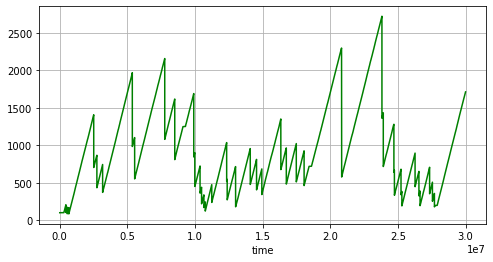

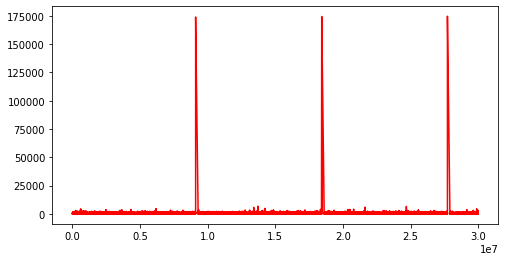



Simulation profile #6:
	 time: 30000000
	 targetLat: 200
	 interval: 1000
	 downSize: 2
	 upSize: 1
	 upSizeLimit: True

	 Simulation running...
Using CoDel algorithm ...
L0 Compaction
L0 Compaction
L0 Compaction
404572.0
	 Simulation done

Results:
	 avg Throughput: 52.678645833333334 MB/s
	 avg Osd Queue Size: 4.709485186617843
	 avg BlueStore Latency: 0.3857359381910911 ms
	 avg KV Queue Latency: 0.1445245122636681 ms



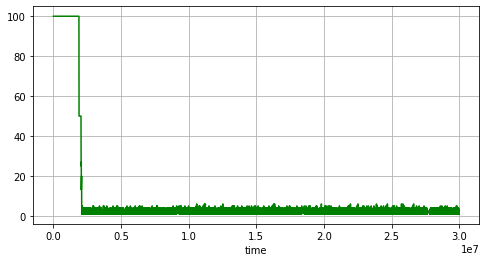

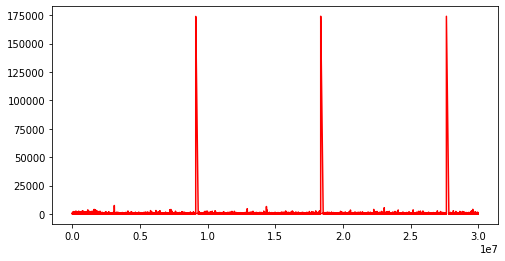



Simulation profile #7:
	 time: 30000000
	 targetLat: 300
	 interval: 1000
	 downSize: 2
	 upSize: 1
	 upSizeLimit: False

	 Simulation running...
Using CoDel algorithm ...
L0 Compaction
L0 Compaction
L0 Compaction
404016.0
	 Simulation done

Results:
	 avg Throughput: 52.60625 MB/s
	 avg Osd Queue Size: 0.49999938121339105
	 avg BlueStore Latency: 1.0769296776443134 ms
	 avg KV Queue Latency: 0.3536064524617329 ms



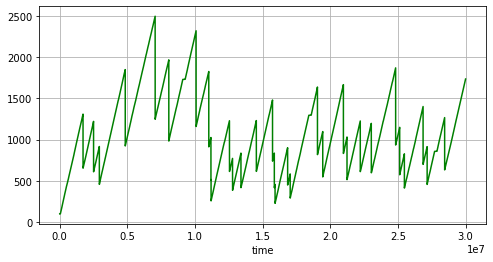

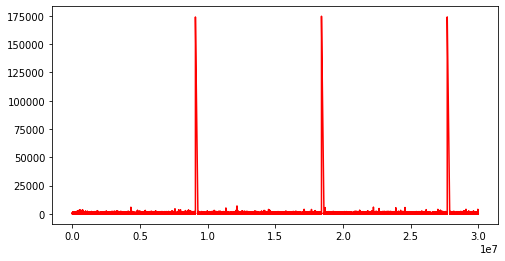



Simulation profile #8:
	 time: 30000000
	 targetLat: 300
	 interval: 1000
	 downSize: 2
	 upSize: 1
	 upSizeLimit: True

	 Simulation running...
Using CoDel algorithm ...
L0 Compaction
L0 Compaction
L0 Compaction
404199.0
	 Simulation done

Results:
	 avg Throughput: 52.630078125 MB/s
	 avg Osd Queue Size: 3.57948370321532
	 avg BlueStore Latency: 0.528536553976116 ms
	 avg KV Queue Latency: 0.20081354836806498 ms



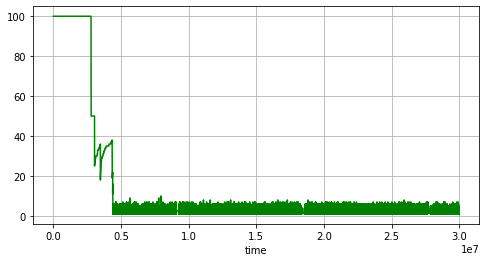

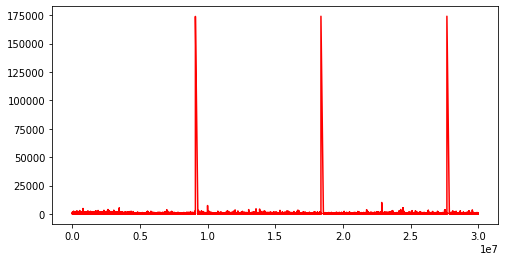



Simulation profile #9:
	 time: 30000000
	 targetLat: 400
	 interval: 1000
	 downSize: 2
	 upSize: 1
	 upSizeLimit: False

	 Simulation running...
Using CoDel algorithm ...
L0 Compaction
L0 Compaction
L0 Compaction
403802.0
	 Simulation done

Results:
	 avg Throughput: 52.57838541666667 MB/s
	 avg Osd Queue Size: 0.49999938089465673
	 avg BlueStore Latency: 1.072698162151901 ms
	 avg KV Queue Latency: 0.3500247706725869 ms



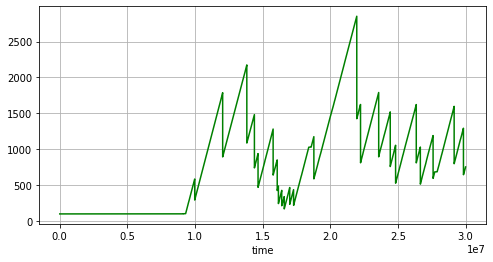

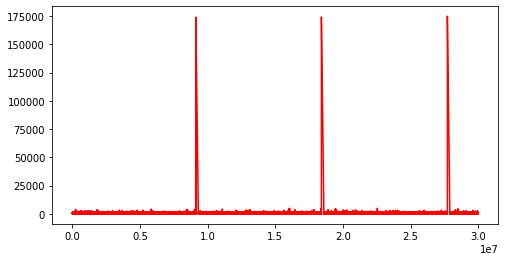



Simulation profile #10:
	 time: 30000000
	 targetLat: 400
	 interval: 1000
	 downSize: 2
	 upSize: 1
	 upSizeLimit: True

	 Simulation running...
Using CoDel algorithm ...
L0 Compaction
L0 Compaction
L0 Compaction
405183.0
	 Simulation done

Results:
	 avg Throughput: 52.758203125 MB/s
	 avg Osd Queue Size: 3.013362982231639
	 avg BlueStore Latency: 0.5986622134365229 ms
	 avg KV Queue Latency: 0.23376059814137434 ms



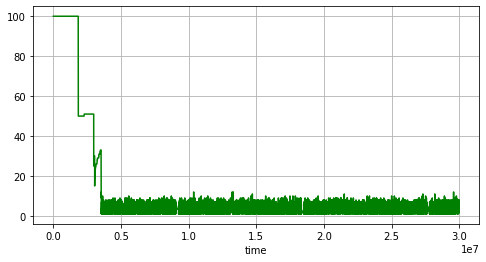

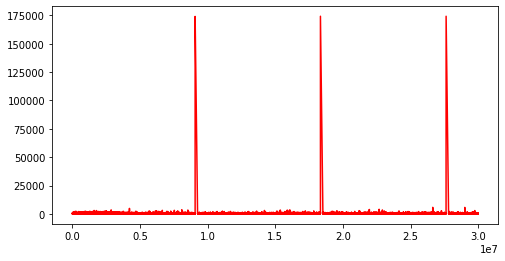



Simulation profile #11:
	 time: 30000000
	 targetLat: 500
	 interval: 1000
	 downSize: 2
	 upSize: 1
	 upSizeLimit: False

	 Simulation running...
Using CoDel algorithm ...
L0 Compaction
L0 Compaction
L0 Compaction
405264.0
	 Simulation done

Results:
	 avg Throughput: 52.76875 MB/s
	 avg Osd Queue Size: 0.49999938311892606
	 avg BlueStore Latency: 1.0646700056372034 ms
	 avg KV Queue Latency: 0.3457749914876585 ms



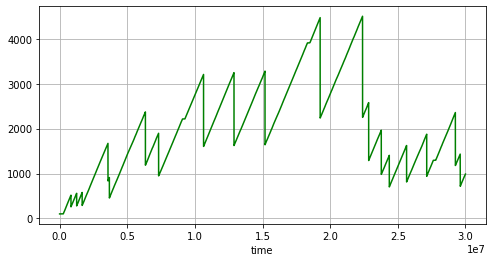

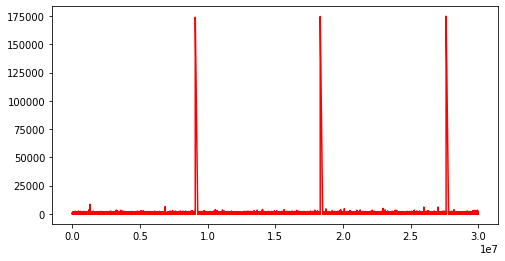



Simulation profile #12:
	 time: 30000000
	 targetLat: 500
	 interval: 1000
	 downSize: 2
	 upSize: 1
	 upSizeLimit: True

	 Simulation running...
Using CoDel algorithm ...
L0 Compaction
L0 Compaction
L0 Compaction
404327.0
	 Simulation done

Results:
	 avg Throughput: 52.64674479166667 MB/s
	 avg Osd Queue Size: 2.4850748575746073
	 avg BlueStore Latency: 0.6979878435133187 ms
	 avg KV Queue Latency: 0.28368542595242324 ms



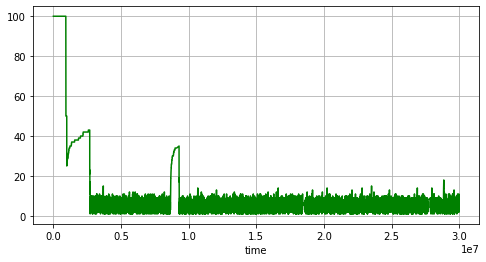

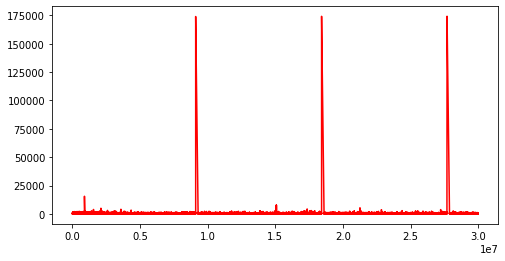



Simulation profile #13:
	 time: 30000000
	 targetLat: 750
	 interval: 1000
	 downSize: 2
	 upSize: 1
	 upSizeLimit: False

	 Simulation running...
Using CoDel algorithm ...
L0 Compaction
L0 Compaction
L0 Compaction
405200.0
	 Simulation done

Results:
	 avg Throughput: 52.760416666666664 MB/s
	 avg Osd Queue Size: 0.4999993830397631
	 avg BlueStore Latency: 1.065186995945493 ms
	 avg KV Queue Latency: 0.3464849181721714 ms



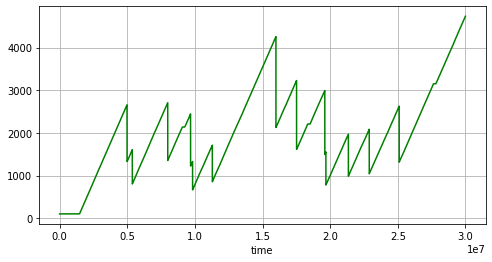

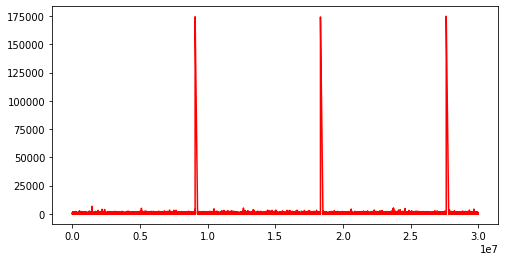



Simulation profile #14:
	 time: 30000000
	 targetLat: 750
	 interval: 1000
	 downSize: 2
	 upSize: 1
	 upSizeLimit: True

	 Simulation running...
Using CoDel algorithm ...
L0 Compaction
L0 Compaction
L0 Compaction
402903.0
	 Simulation done

Results:
	 avg Throughput: 52.461328125 MB/s
	 avg Osd Queue Size: 0.7795456068461769
	 avg BlueStore Latency: 1.0068808717372948 ms
	 avg KV Queue Latency: 0.3351001854752663 ms



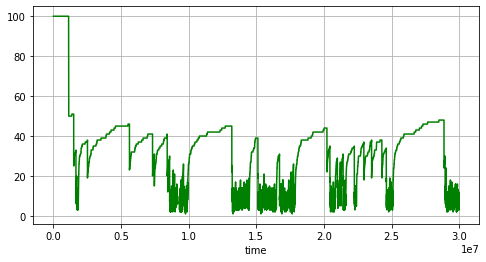

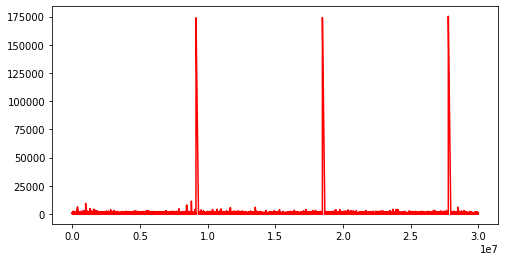



Simulation profile #15:
	 time: 30000000
	 targetLat: 1000
	 interval: 1000
	 downSize: 2
	 upSize: 1
	 upSizeLimit: False

	 Simulation running...
Using CoDel algorithm ...
L0 Compaction
L0 Compaction
L0 Compaction
404104.0
	 Simulation done

Results:
	 avg Throughput: 52.61770833333333 MB/s
	 avg Osd Queue Size: 0.49999938135732674
	 avg BlueStore Latency: 1.0754686126921604 ms
	 avg KV Queue Latency: 0.3555424868198755 ms



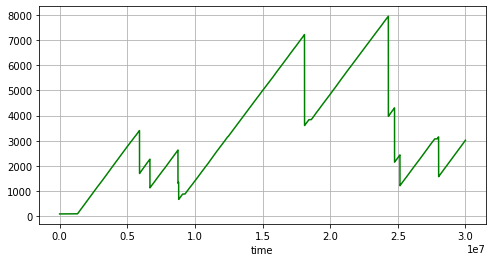

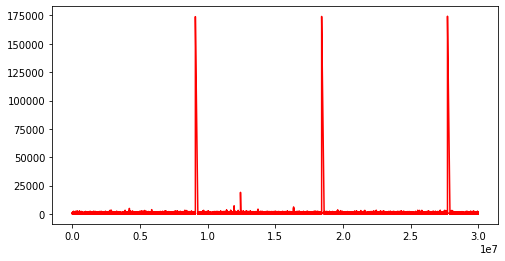



Simulation profile #16:
	 time: 30000000
	 targetLat: 1000
	 interval: 1000
	 downSize: 2
	 upSize: 1
	 upSizeLimit: True

	 Simulation running...
Using CoDel algorithm ...
L0 Compaction
L0 Compaction
L0 Compaction
403392.0
	 Simulation done

Results:
	 avg Throughput: 52.525 MB/s
	 avg Osd Queue Size: 0.5371170758008639
	 avg BlueStore Latency: 1.0632599175669388 ms
	 avg KV Queue Latency: 0.346970857150934 ms



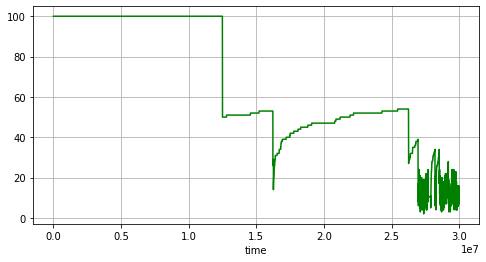

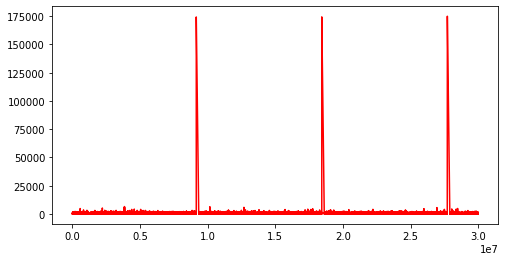

In [6]:
targetLatSettings = [50, 100, 200, 300, 400, 500, 750, 1000]
intervalSettings = [1000]
batchDownSizeSettings = [2]
batchUpSizeSettings = [1]

runSimulations(targetLatSettings,
                   intervalSettings,
                   batchDownSizeSettings,
                   batchUpSizeSettings,
                   upSizeLimitSettings=[False, True]
                  )